## Import libraries

In [1]:
import glob
from tqdm import tqdm
import datetime
import re
import pandas as pd
import seaborn as sns
import warnings
import os
import pickle
import numpy as np
import utils as ut
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm
import matplotlib.patches as mpatches
import matplotlib
from scipy import stats
import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter, MaxNLocator
warnings.simplefilter(action='ignore', category=FutureWarning)

## Fetch data

In [2]:
Animal_List = [
               'QP032', 
               'QP033', 
               'QP034',
               'QP049',
               'QP050', 
               'QP051', 
               'QP062', 'QP063', 'QP070', 'QP071', 'QP079', 
               'QP081', 'QP082'
               ]

# Define the path to the cache file
cache_path = '/Users/quentin/Desktop/HeadFixedBehavior/Data/'
cache_file = os.path.join(cache_path, "all_data_cont.pkl")

# Define the path to the figures
figs_path = '/Users/quentin/Desktop/HeadFixedBehavior/Analysis/Figures/'

# Check if the cache file exists
if os.path.exists(cache_file):
    # If the cache file exists, load the data from the cache
    with open(cache_file, "rb") as f:       
        all_data_cont = pickle.load(f)
else:
    # If the cache file does not exist, load the data from the remote server
    all_data_cont = pd.DataFrame()
    for animal in Animal_List:
        try:
            # Load the data for the current animal and add it to the dictionary
            animal_data = ut.get_animal_data('/Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/',
                                             animal, 
                                             'SOUND_CAT_CONT',
                                             'Trial_Summary')
            all_data_cont = pd.concat([all_data_cont, animal_data])
        except:
            # If there is an error loading the data, skip the current animal
            pass

    # Save the data to the cache file
    with open(cache_file, "wb") as f:
        pickle.dump(all_data_cont, f)

Processing QP082: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


## Filter data

In [12]:
data_df = ut.relabel_ELV(all_data_cont) # Re-label appropriately
# TODO: change block removal with date removal
data_df = ut.remove_blocks(data_df, 'QP032', [17, 18]) # blocks with wrong distribution
data_df = ut.remove_blocks(data_df, 'QP070', [38, 39, 
                                              49
                                              ]) # spout alignment problem
# only keep data where antibias is False or np.nan
data_df = data_df[(data_df.Anti_Bias == False) | (pd.isna(data_df.Anti_Bias))].reset_index(drop=True)
data_df = ut.filter_min_trials(data_df, 100) # Keep at least 100 valid trials per sessions
data_df = ut.threshold_cutoff(data_df, threshold = 0.7) # Only keep sessions where %correct is > threshold

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    data_df = ut.filter_lapses(data_df, threshold = 0.75) # Remove sessions with lapse rates > 20%
    
data_df = ut.add_dist_block(data_df) # Track distribution and mouse specific block_nbs
data_df = ut.check_distributions(data_df, n = 1) # Check thal all subjects have been exposed to n distributions
# data_df = make_blocks_equal(data_df) # Check that all subjects have same number of blocks on each distribution (optional) 
data_df = data_df[data_df['Distribution'].notna()].reset_index(drop=True) # Check distributions are valid
# Ensure thal all blocks follow the desired order (e.g.   ['Uniform', 'Asym_right', 'Asym_left']) (optional)
# data_df = sort_consec_dist(data_df, ['Uniform', 'Asym_right', 'Asym_left']) 

In [15]:
# add cohort_ID
cohort_1 = ['QP032', 'QP033', 'QP034', 'QP049', 'QP050', 'QP051']
cohort_2 = ['QP062', 'QP063', 'QP070', 'QP071', 'QP079']
data_df = ut.add_cohort_ids(data_df, [cohort_1, cohort_2])

# # drop the stim_relative_binned column from the dataframe
# data_df = data_df.drop(columns=['stim_relative_binned'])

In [5]:
# p_ids = ['QP062', 'QP081', 'QP082']
# data_df = data_df[(data_df['stim_relative'] >= -1) & (data_df['stim_relative'] <= 1) & (data_df['Participant_ID'].isin(p_ids))]
# # re-index the dataframe
# data_df = data_df.reset_index(drop=True)

In [30]:
# remove all rows of data_df where stim_relative is not between -1 and 1, then reindex
data_df = data_df[(data_df['stim_relative'] >= -1) & (data_df['stim_relative'] <= 1)]
data_df = data_df.reset_index(drop=True)

## Set Font Params

In [6]:
ut.set_plot_font(font_family='sans-serif', title_font_size=14, label_font_size=14, sans_serif_font='Helvetica')

## Save to cache

In [35]:
data_df.to_csv(cache_path + 'Data_Sound_Cat.csv') # save dataframe as .csv

In [8]:
# break execution at this cell
raise KeyboardInterrupt("Stopped execution at this cell.")

KeyboardInterrupt: Stopped execution at this cell.

## Check distributions

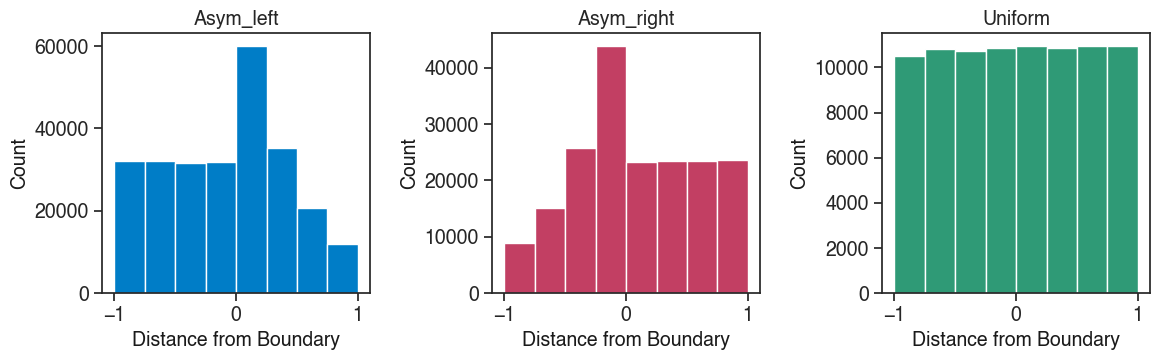

In [31]:
color_dict = {'Uniform': '#2F9A76', 'Asym_left': '#007dc7', 'Asym_right': '#c23f63'}
ut.plot_dist_hist(data_df, color_dict, 8)

## Plot % correct & bias over sessions

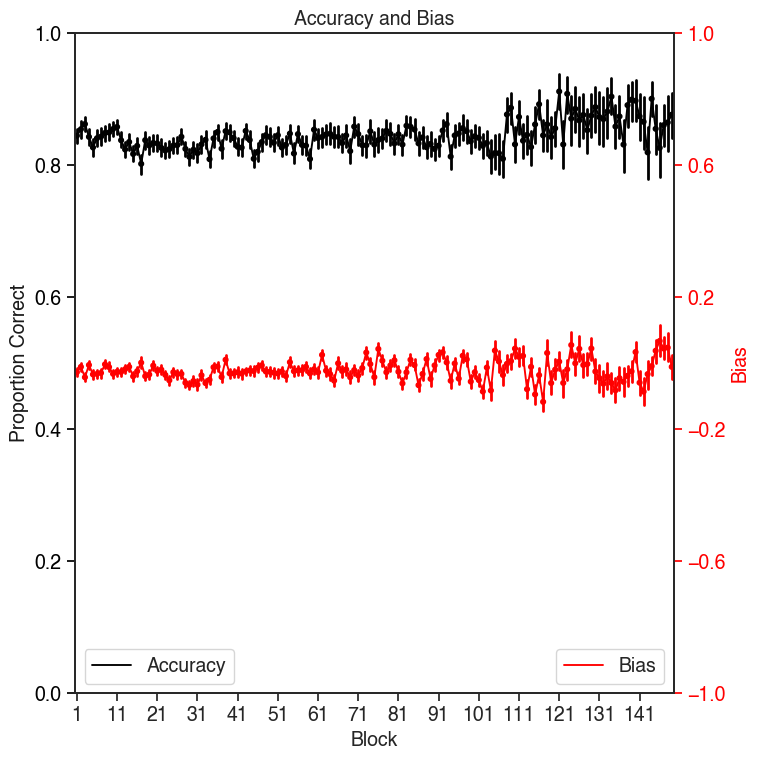

In [17]:
ut.plot_performance_and_bias_mega_sub(data_df, ['QP032', 'QP033', 'QP034','QP049', 'QP050',
                                                'QP062', 'QP063', 'QP070', 'QP071', 'QP079'])

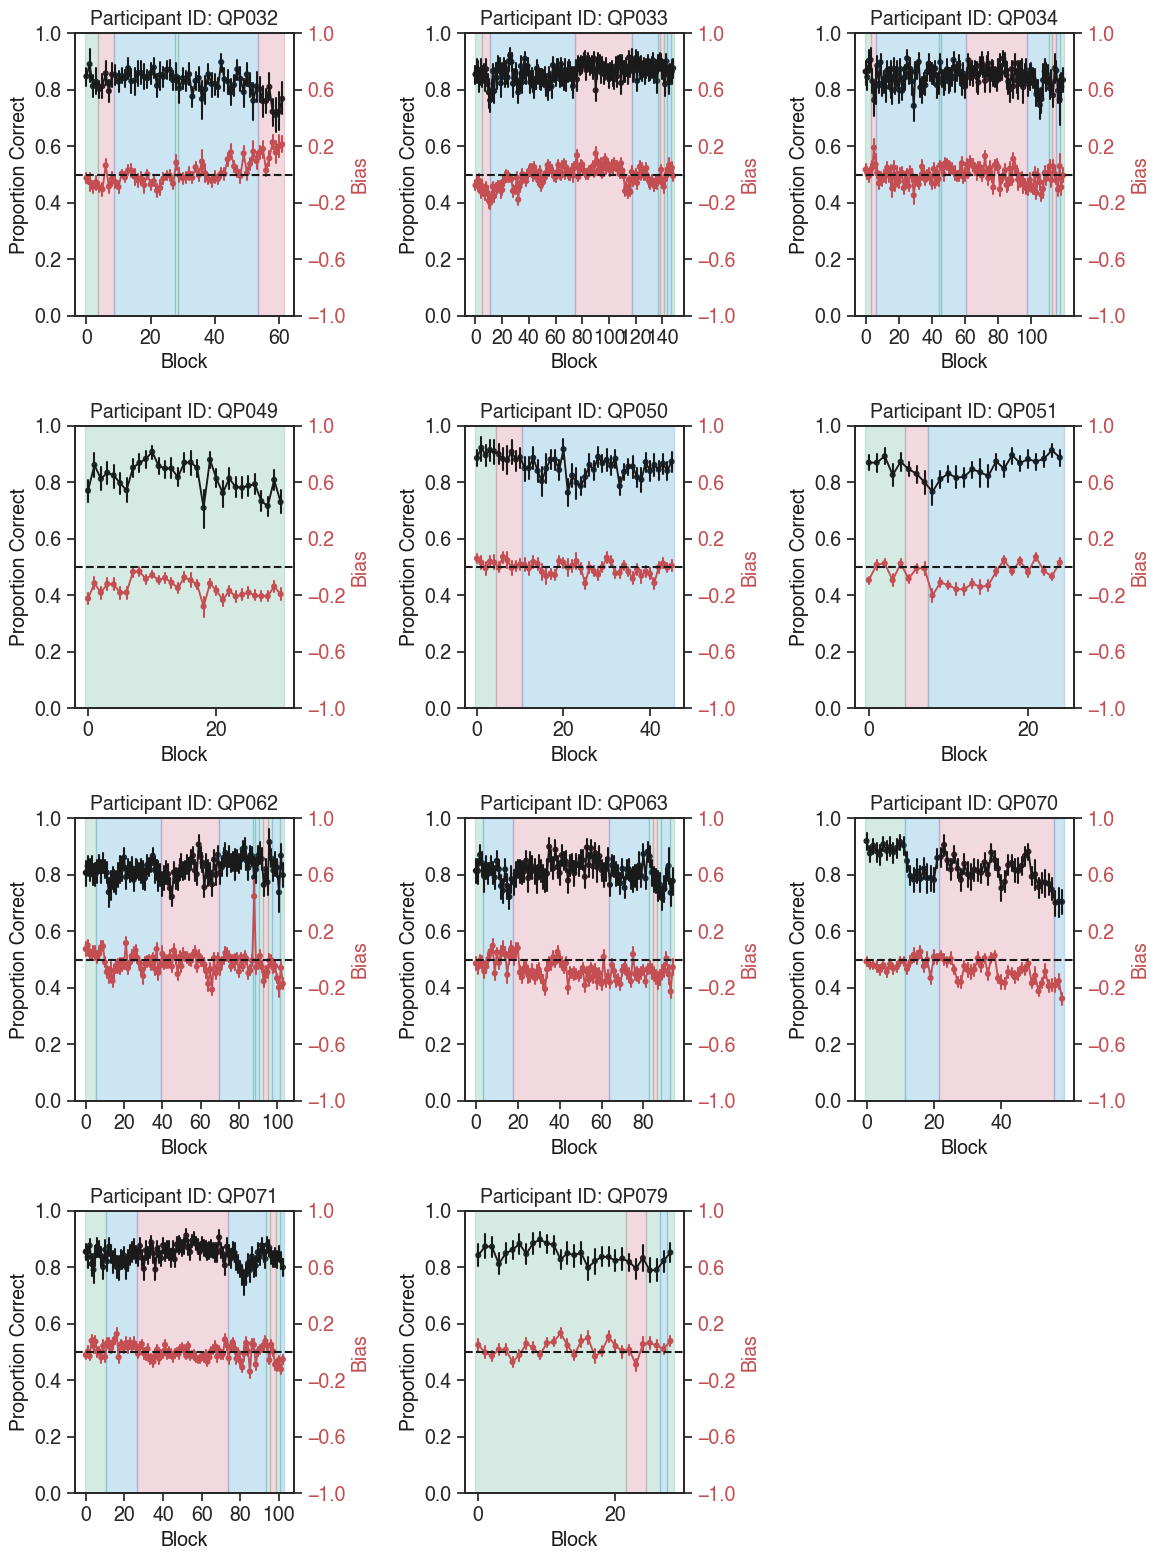

In [34]:
ut.plot_performance_and_bias(df = data_df,
                             participant_ids = ['QP032', 'QP033', 'QP034','QP049', 'QP050',
                                                'QP051', 'QP062', 'QP063', 'QP070', 'QP071', 'QP079'],
                             distributions = ['Uniform', 'Asym_left', 'Asym_right'],
                             background_shading = True,
                             color_dict = {'Uniform': '#2F9A76', 'Asym_left': '#007dc7', 'Asym_right': '#c23f63'})                             

## Plot psychometrics

### Mega Subject

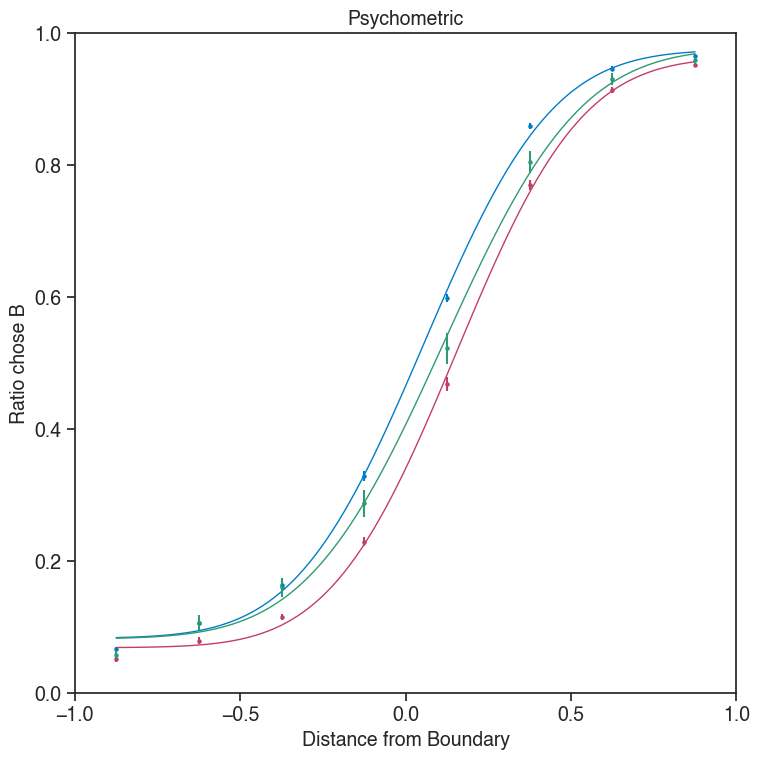

In [ ]:
ut.psycho_plot_mega_sub(df = data_df, 
                        participant_ids = [
                                        'QP032', 'QP033', 'QP034', 'QP050', 'QP051', 
                                        'QP062', 'QP063', 'QP070', 'QP071'
                                        ],                     
                        distributions = [
                                        'Asym_left', 
                                        'Asym_right', 
                                        'Uniform',
                                        ],
                        color_dict = {'Uniform': '#2F9A76', 'Asym_left': '#007dc7', 'Asym_right': '#c23f63'},
                        title='Psychometric',
                        stim_dur_separate = False,
                        legend = False,
                        )

### Individual Subjects

<Figure size 1800x1600 with 0 Axes>

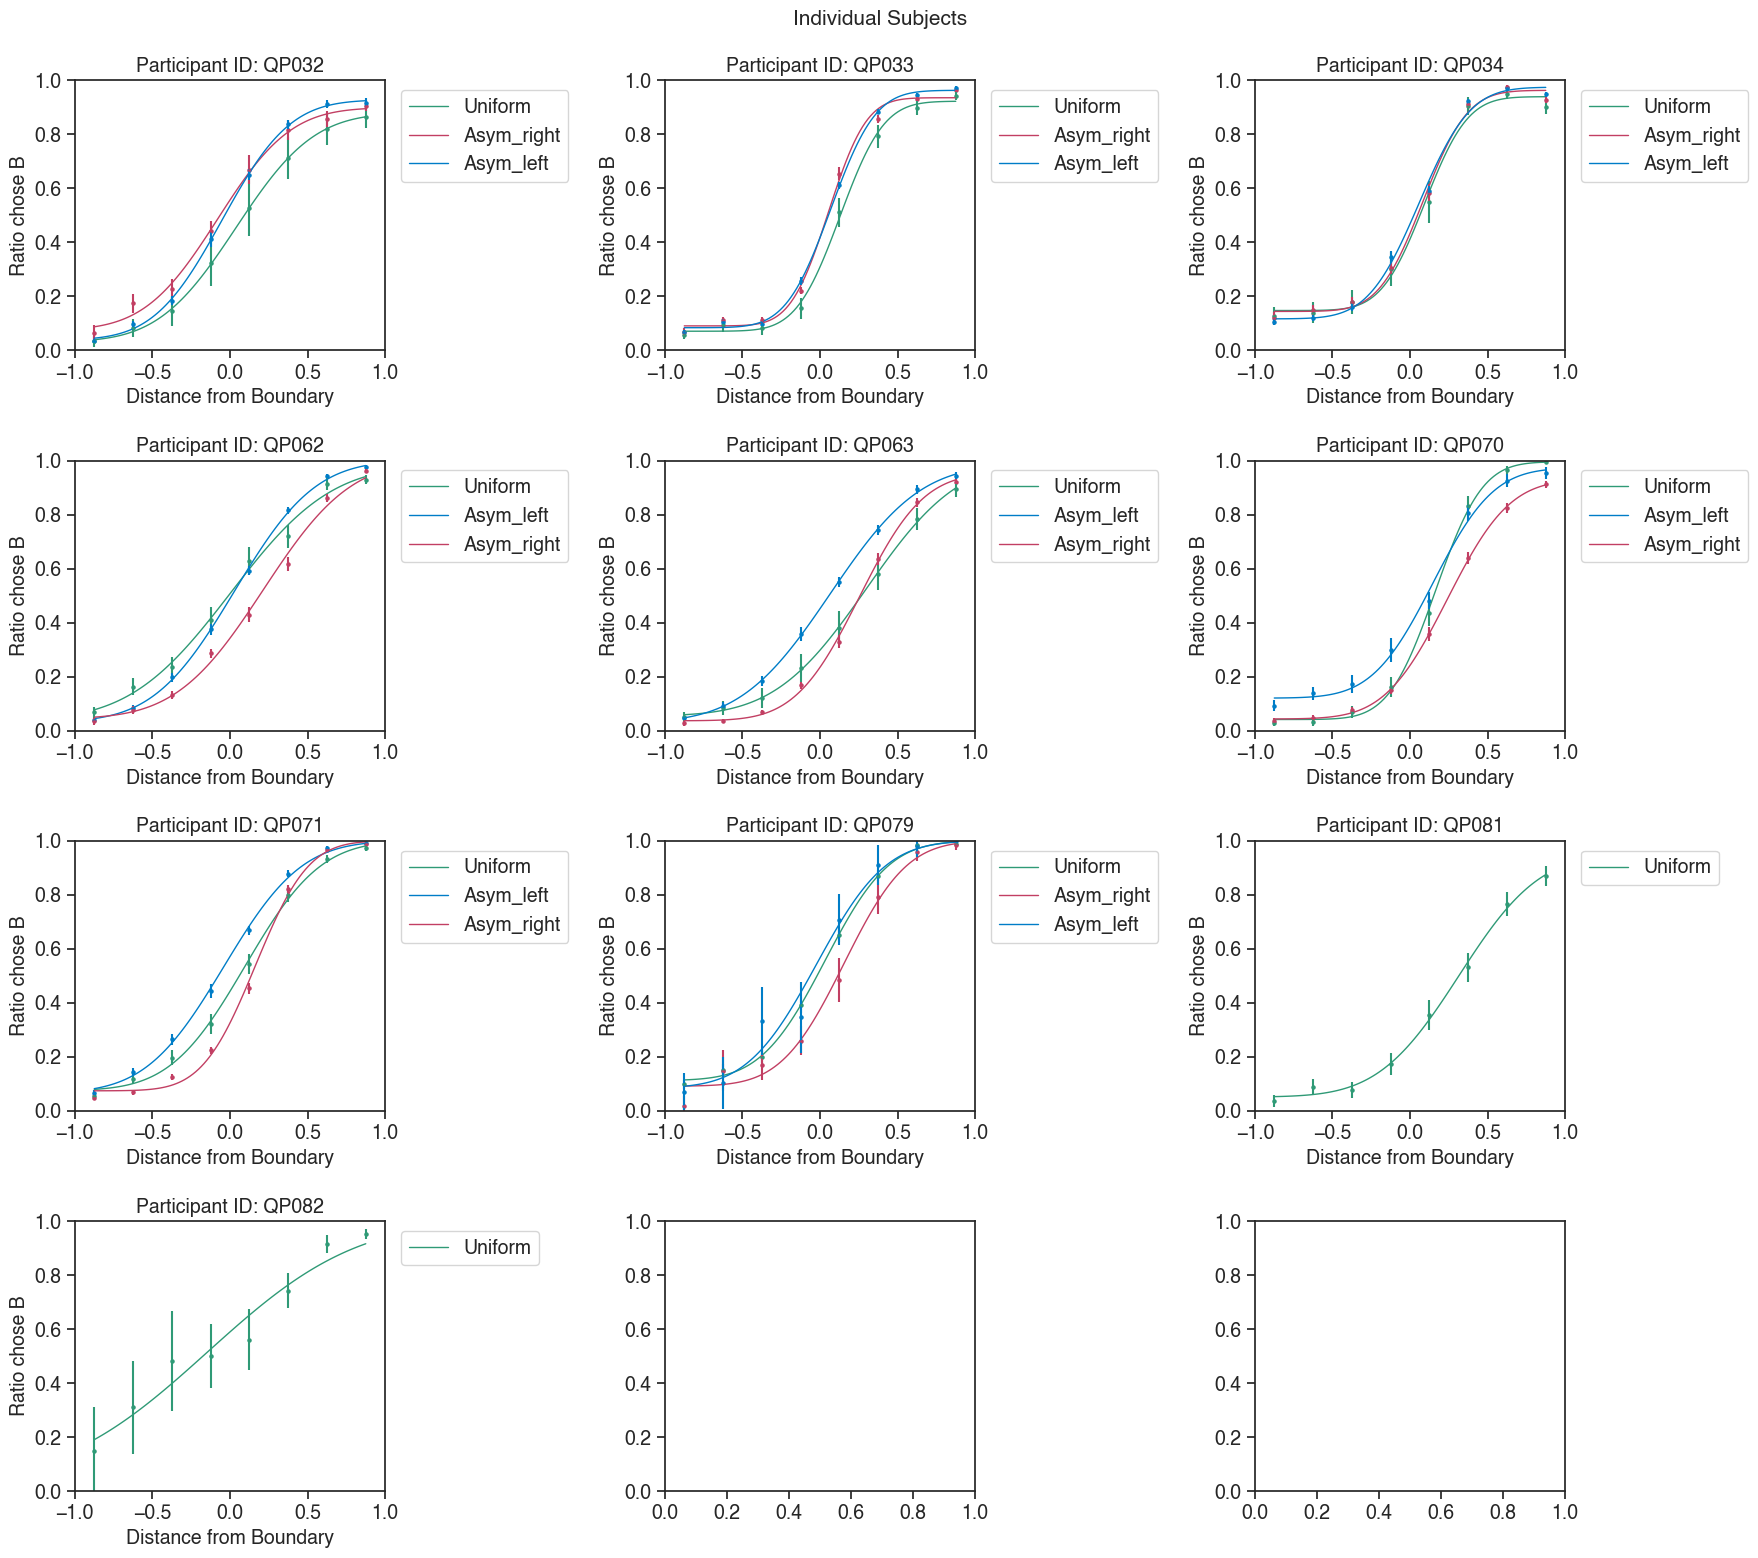

In [18]:
ut.psycho_plot_individual(df=data_df,
                          participant_ids = ['QP032', 'QP033', 'QP034','QP049', 'QP050',
                                             'QP051', 'QP062', 'QP063', 'QP070', 'QP071', 
                                             'QP079', 'QP081', 'QP082'],
                          distributions = ['Uniform', 
                                           'Asym_left', 
                                           'Asym_right'
                                          ])

In [ ]:
# ut.psycho_plot_individual(df=data_df,
#                           participant_ids = ['QP032', 'QP033', 'QP034','QP049', 'QP050',
#                                              'QP051', 'QP062', 'QP063', 'QP070', 'QP071'],
#                           distributions = ['Uniform', 
#                                            'Asym_left', 
#                                            'Asym_right'],
#                           plot_learning_gradient = True)                                    

In [ ]:
# ut.psycho_plot_individual(df=data_df,
#                           participant_ids = ['QP032', 'QP033', 'QP034','QP049', 'QP050',
#                                              'QP051', 'QP062', 'QP063', 'QP070', 'QP071'],
#                           distributions = ['Uniform', 
#                                            'Asym_left', 
#                                            'Asym_right'],
#                         color_dict = {'Uniform': ['#00FF00', '#008B00'],
#                                       'Asym_left': ['#0000FF', '#00008B'],
#                                       'Asym_right': ['#FF0000', '#8B0000']},
#                         stim_dur_separate = True)

### Psycho Params

In [6]:
p_ids = [
         'QP033',
         'QP034',
         'QP062', 
         'QP063', 
         'QP070', 
         'QP071', 
         'QP079', 
         ]
psych_params_df = ut.gen_blockwise_psych_params(data_df, p_ids)                       

/Users/quentin/anaconda3/envs/sound_cat/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/quentin/anaconda3/envs/sound_cat/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/quentin/anaconda3/envs/sound_cat/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/quentin/anaconda3/envs/sound_cat/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/quentin/anaconda3

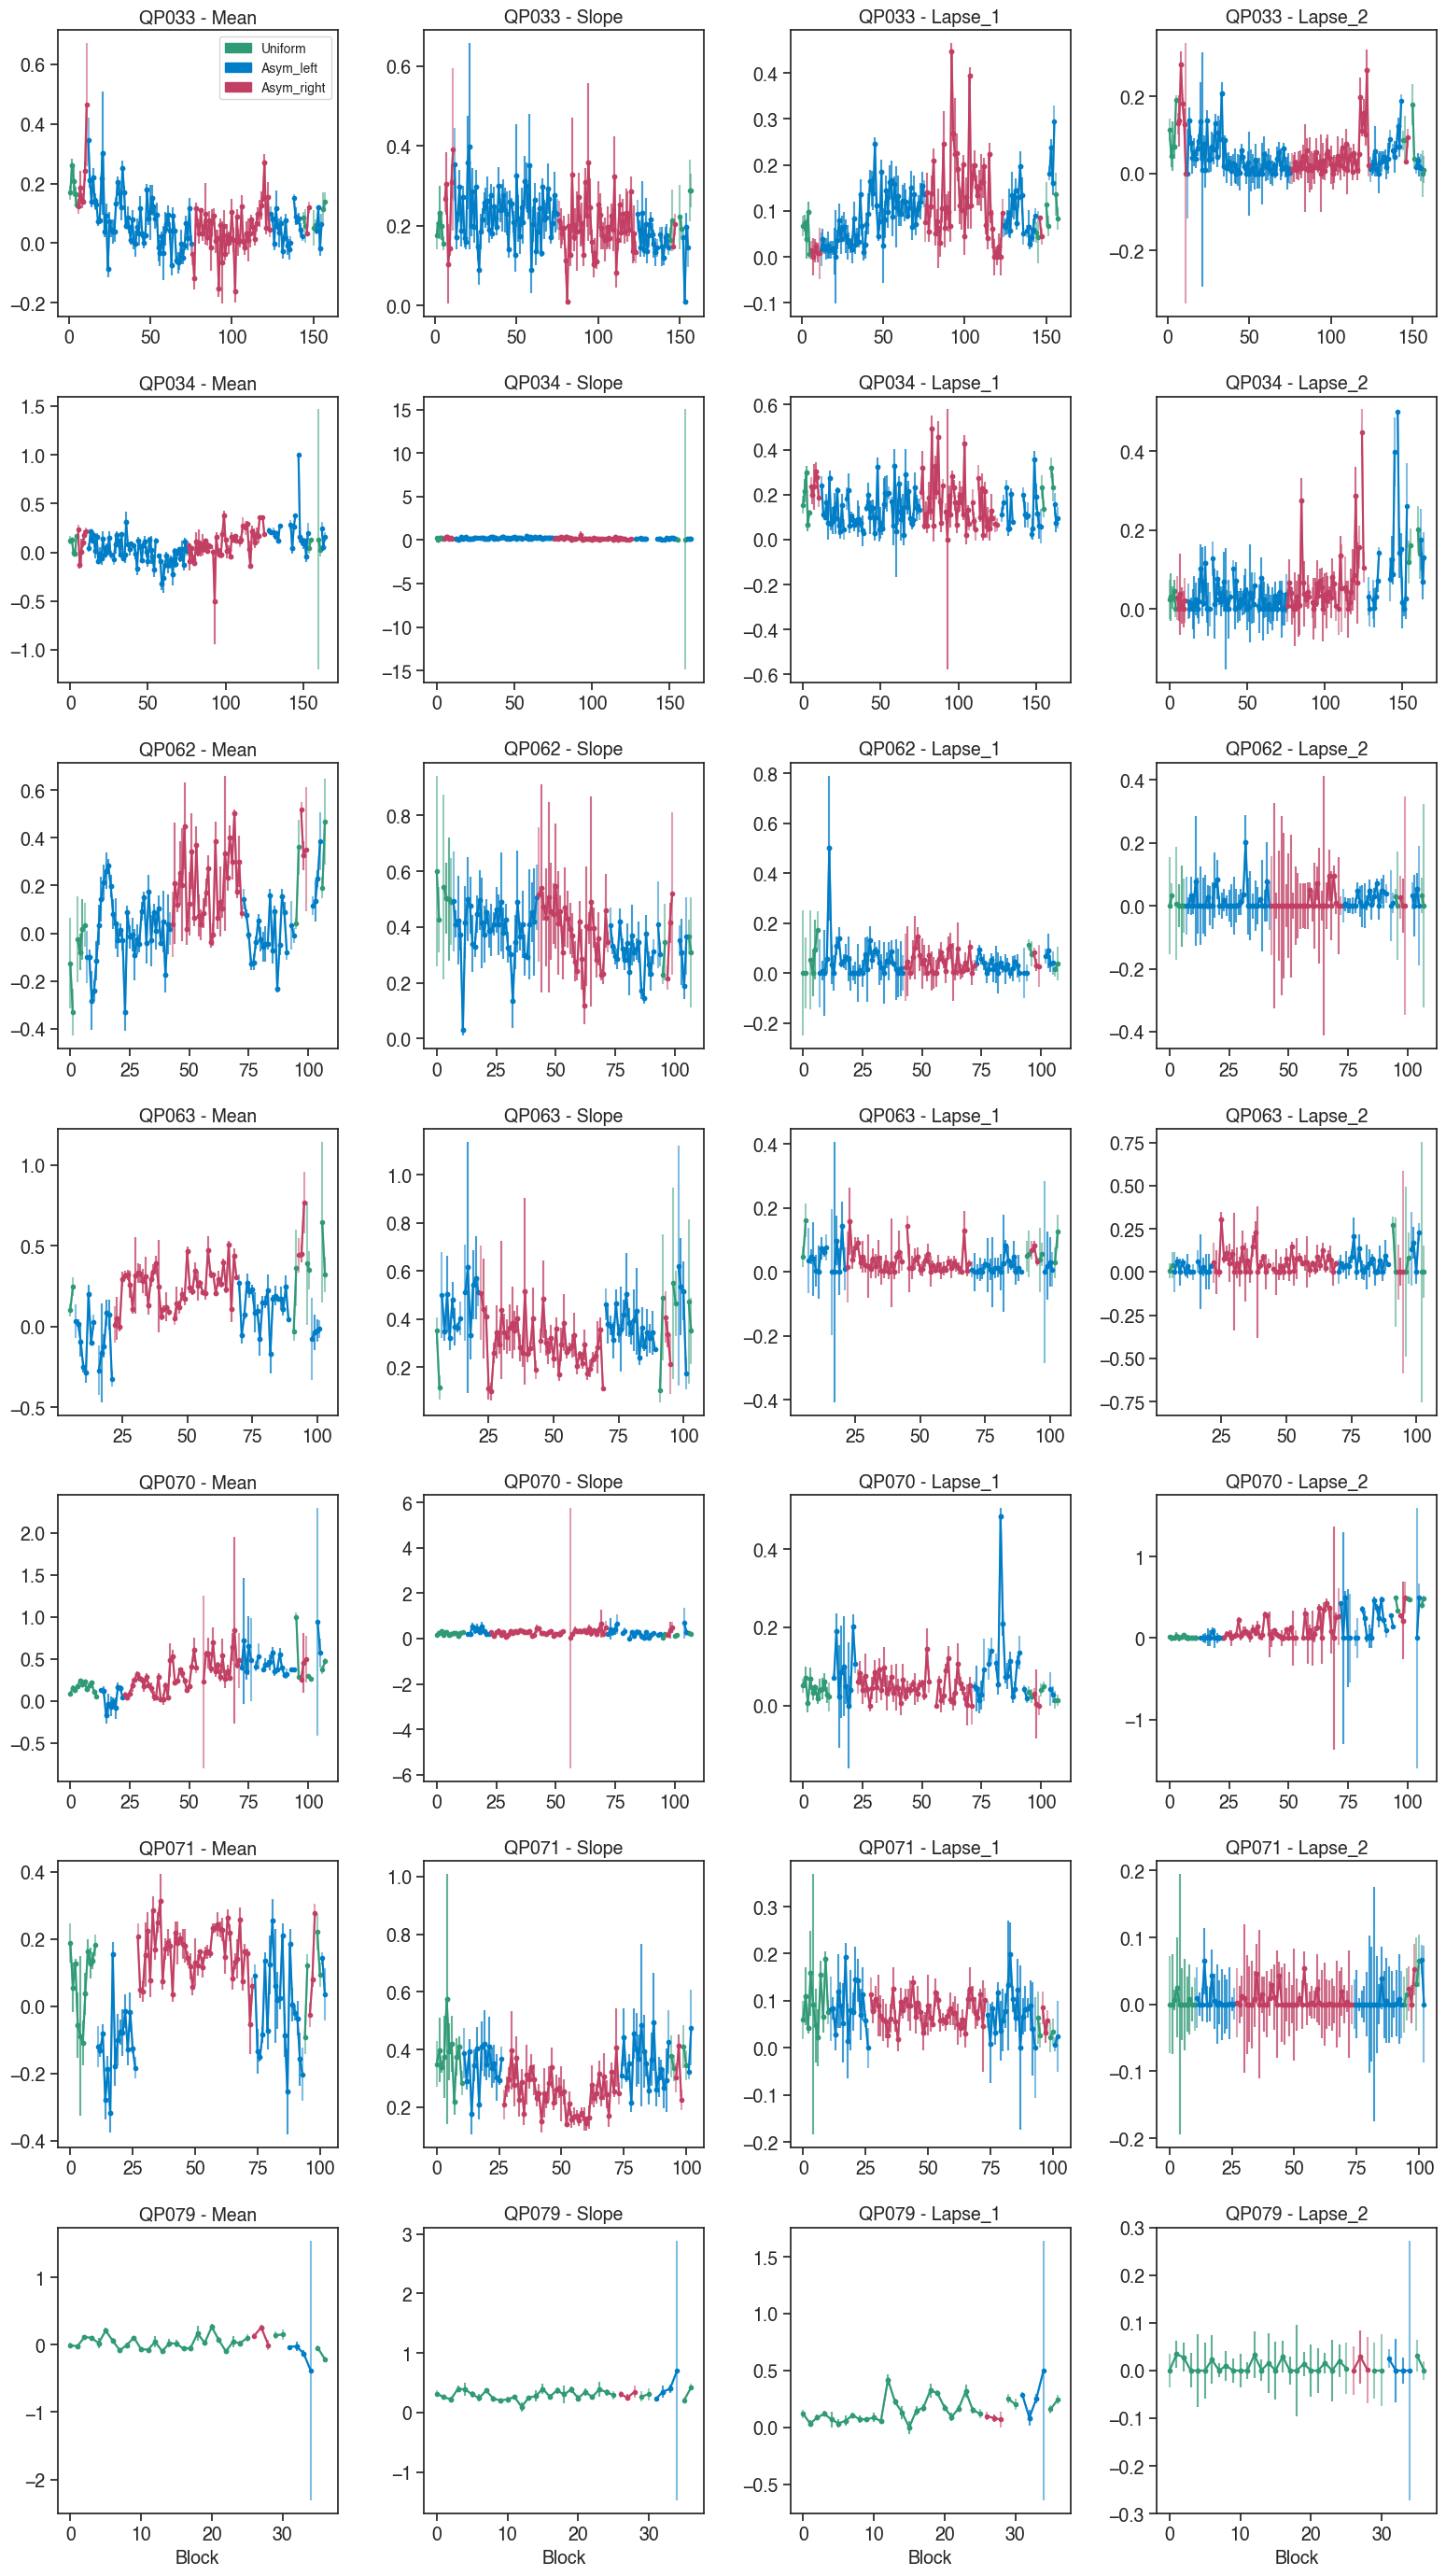

In [12]:
clean_psych_params_df = psych_params_df[psych_params_df.Block_Means_Std <= 2] # remove outliers
ut.plot_blockwise_psych_params(df = clean_psych_params_df, 
                               participant_ids = p_ids)

In [15]:
clean_psych_params_df

,Participant_ID,Block,Distribution,Block_Means,Block_Slopes,Block_Lapses_1,Block_Lapses_2,Block_Means_Std,Block_Slopes_Std,Block_Lapses_1_Std,Block_Lapses_2_Std
0,QP032,0,Uniform,0.085259,0.291134,6.747099e-02,9.462586e-02,5.503344e-02,7.543904e-02,0.044895,0.055093
1,QP032,1,Uniform,0.167713,0.218585,4.520203e-02,2.769689e-02,4.041115e-02,5.467917e-02,0.038503,0.052570
2,QP032,2,Uniform,-0.120101,0.010000,7.478343e-02,3.104384e-01,4.528207e-03,2.218167e-03,0.064859,0.056169
3,QP032,3,Uniform,0.506881,0.237242,1.555268e-02,3.038587e-01,4.289874e-02,5.106425e-02,0.015529,0.063099
4,QP032,4,Uniform,0.337706,0.465504,4.859611e-02,1.554946e-21,1.159370e-01,1.339947e-01,0.041374,0.158188
...,...,...,...,...,...,...,...,...,...,...,...
894,QP082,2,Uniform,0.763738,0.016875,2.375000e-01,1.000000e-01,2.653861e-09,1.326930e-08,0.178098,0.356195
895,QP082,3,Uniform,0.239119,0.342987,3.750715e-02,1.074589e-02,1.631711e-01,2.384584e-01,0.342221,0.134366
896,QP082,5,Uniform,-0.944345,0.658529,1.489998e-16,3.885936e-02,1.845896e+00,9.039810e-01,2.308306,0.054943
897,QP082,6,Uniform,0.303447,0.284242,2.731420e-01,2.591525e-02,3.821483e-02,6.073148e-02,0.055552,0.034868


In [13]:
# obtain psychometric parameters for last 10 blocks

# Sort the dataframe by 'Participant_ID' and 'block' in descending order
psych_params_sorted = clean_psych_params_df.sort_values(by=['Participant_ID', 'Block'], ascending=[True, True])

# Group the dataframe by 'Participant_ID' and keep the last 10 blocks from each group
psych_params_last_10_blocks = psych_params_sorted.groupby('Participant_ID').tail(20)

# Optionally, you can reset the index if needed
psych_params_last_10_blocks = psych_params_last_10_blocks.reset_index(drop=True)

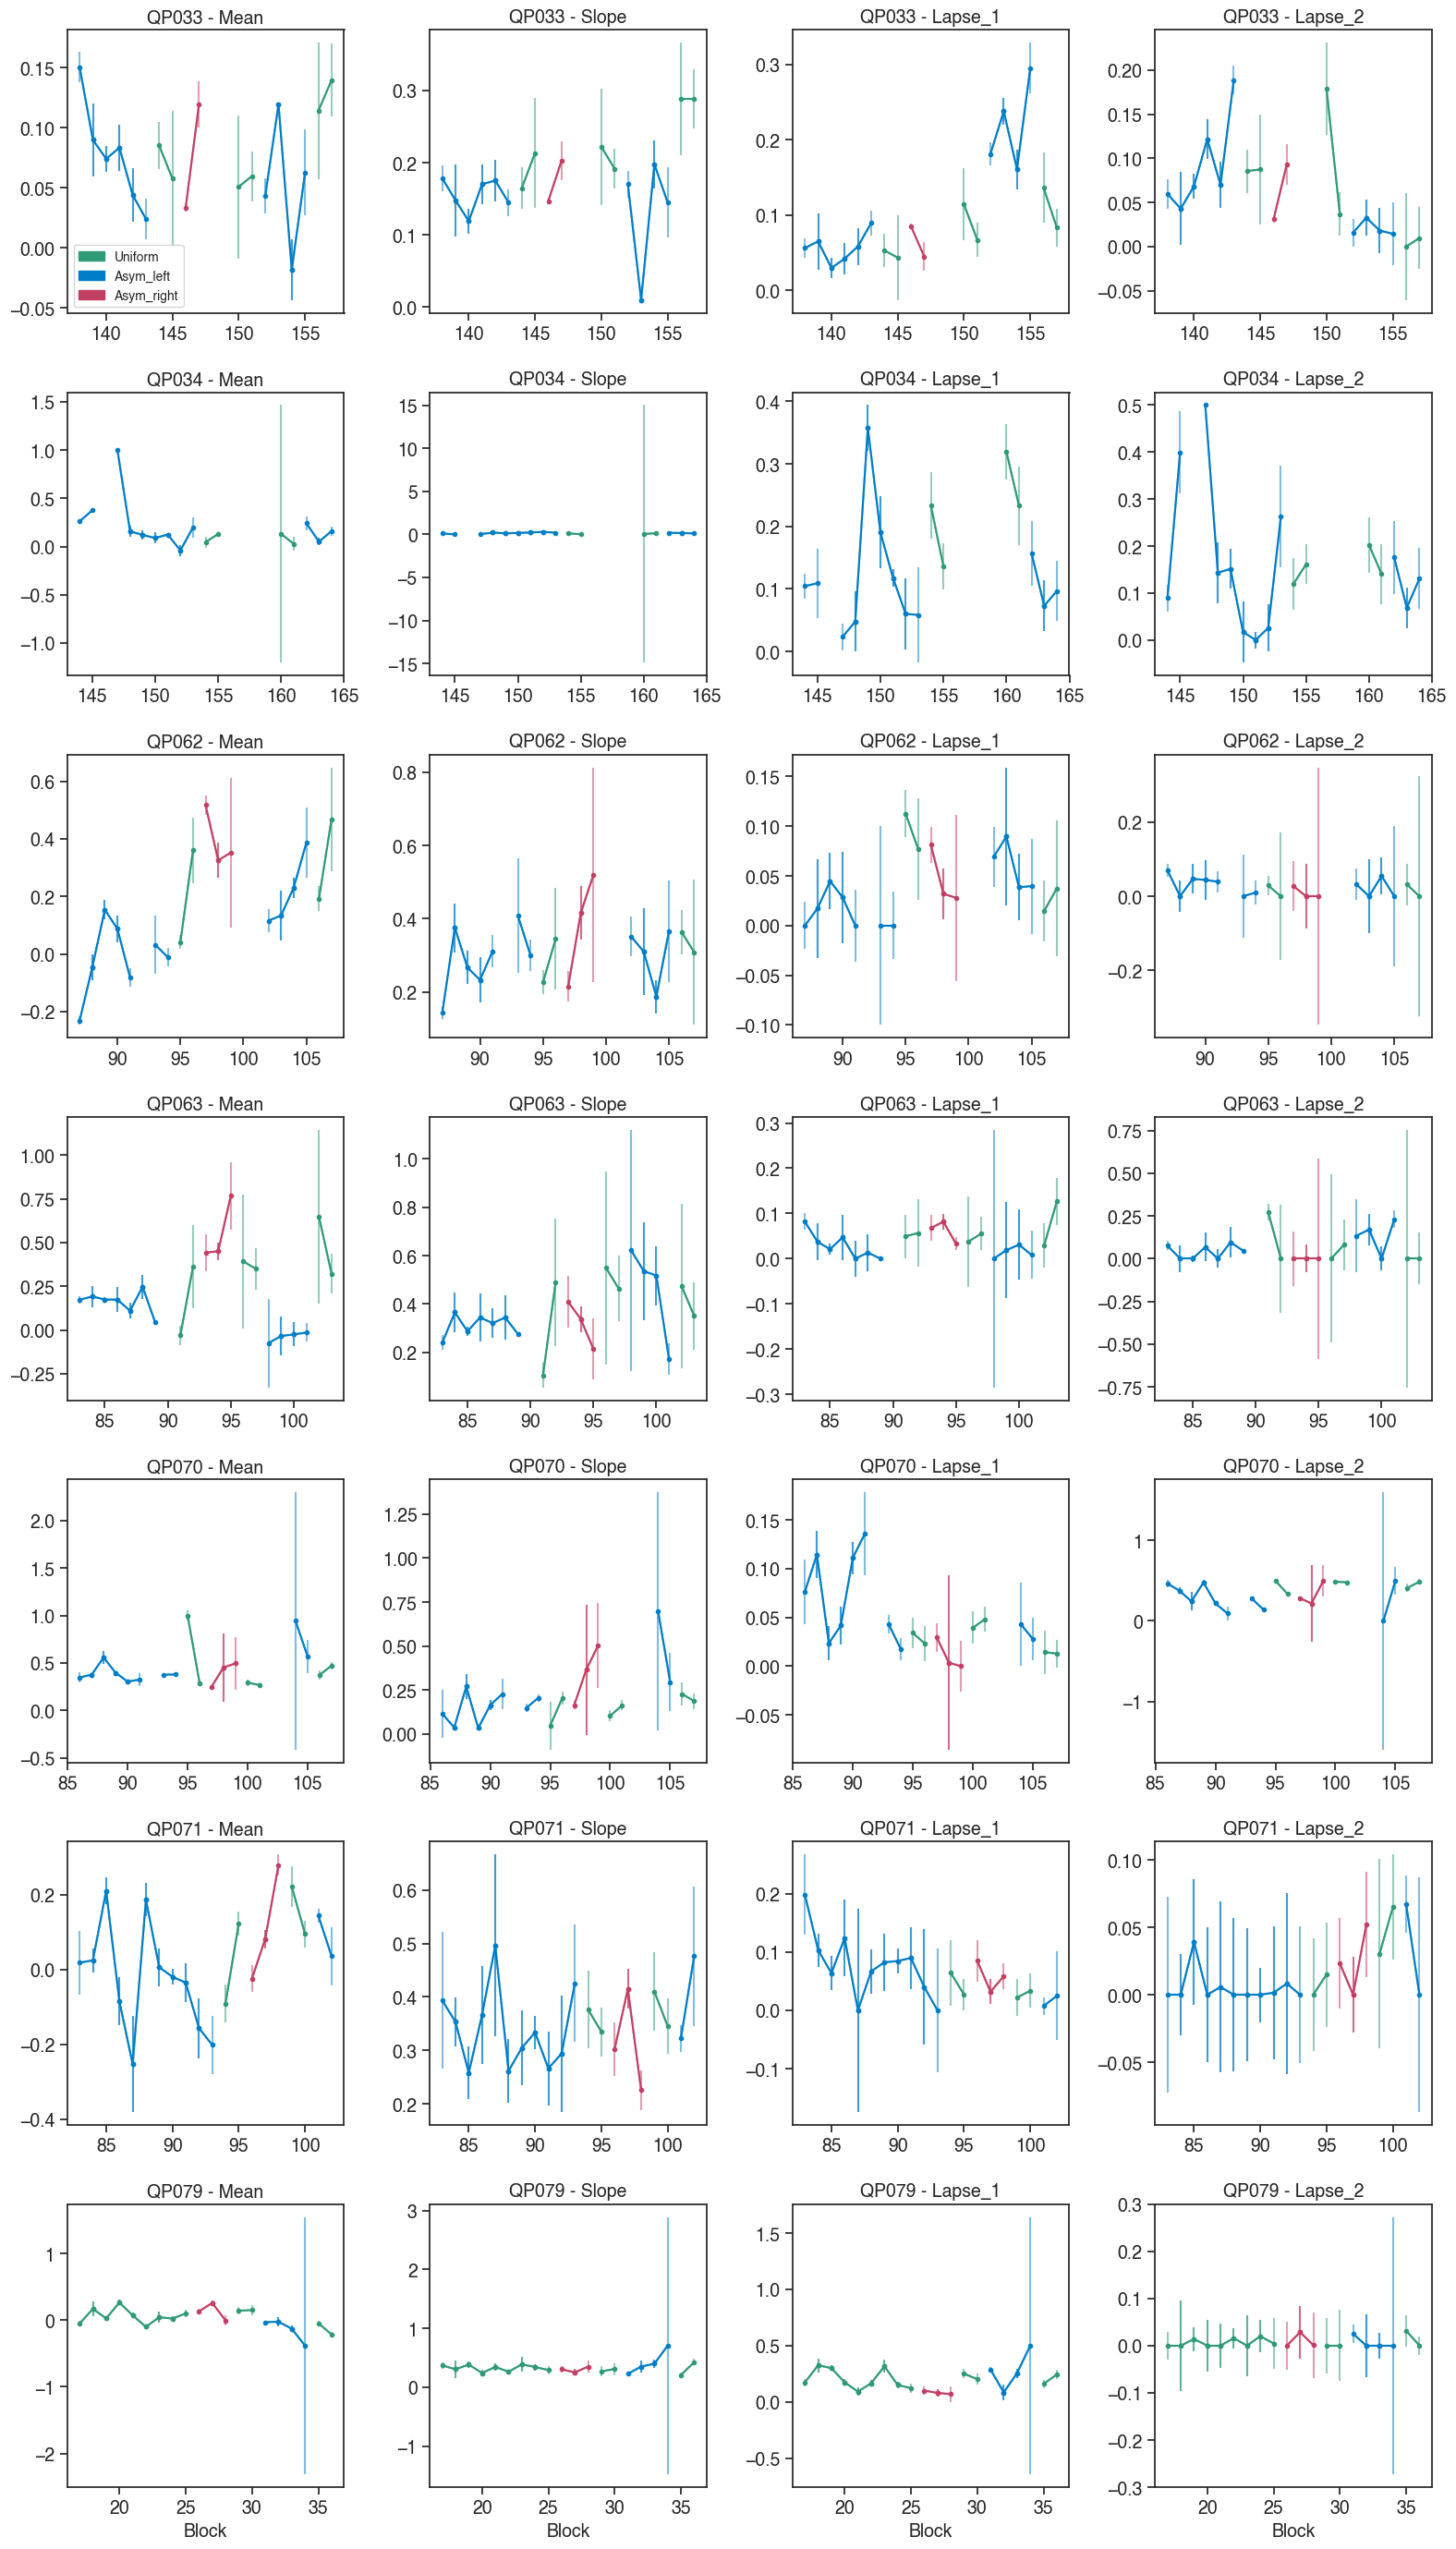

In [14]:
ut.plot_blockwise_psych_params(df = psych_params_last_10_blocks, 
                               participant_ids = p_ids)

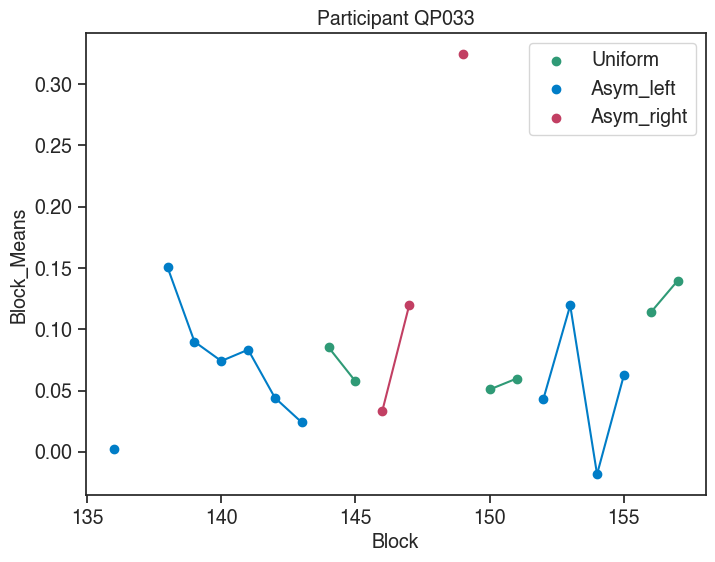

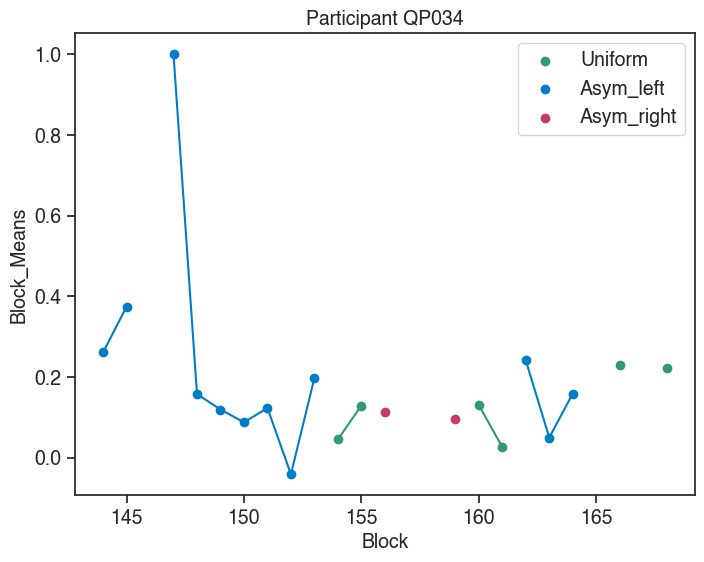

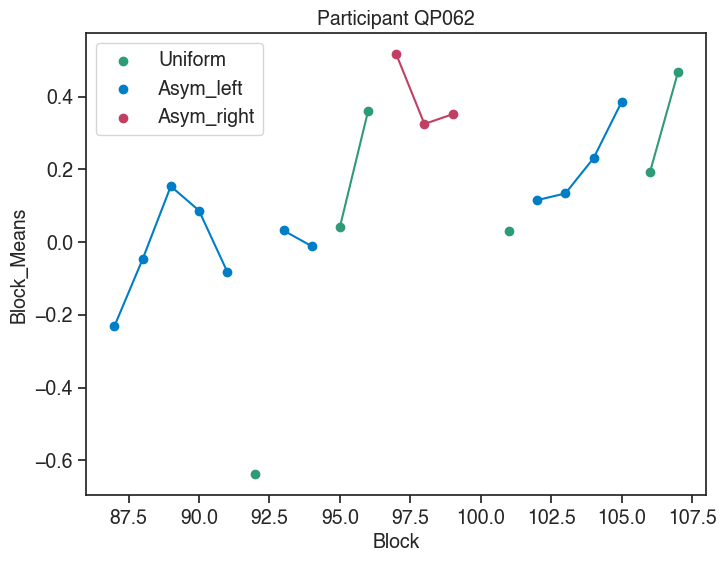

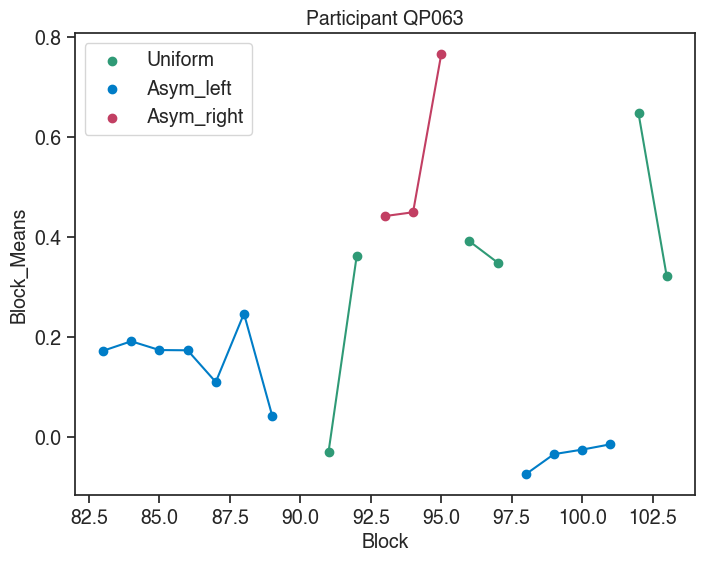

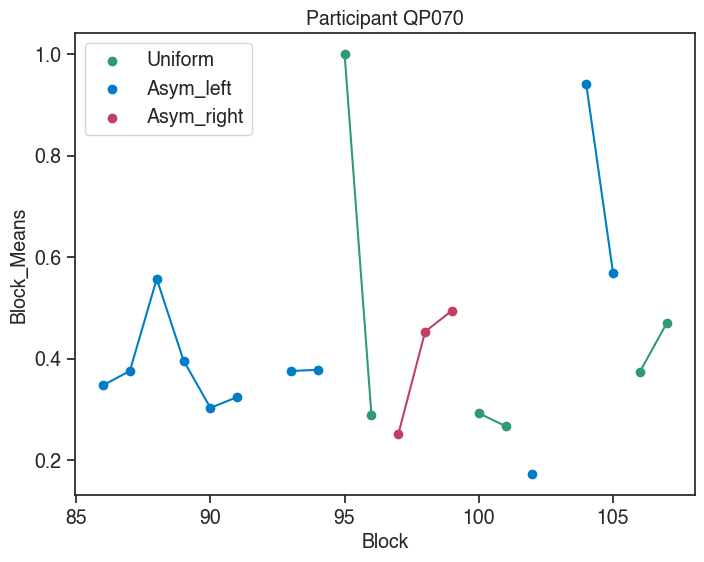

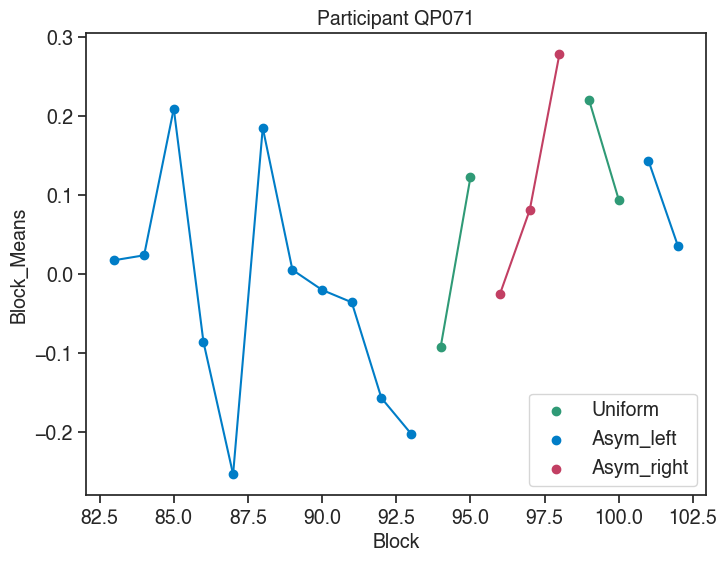

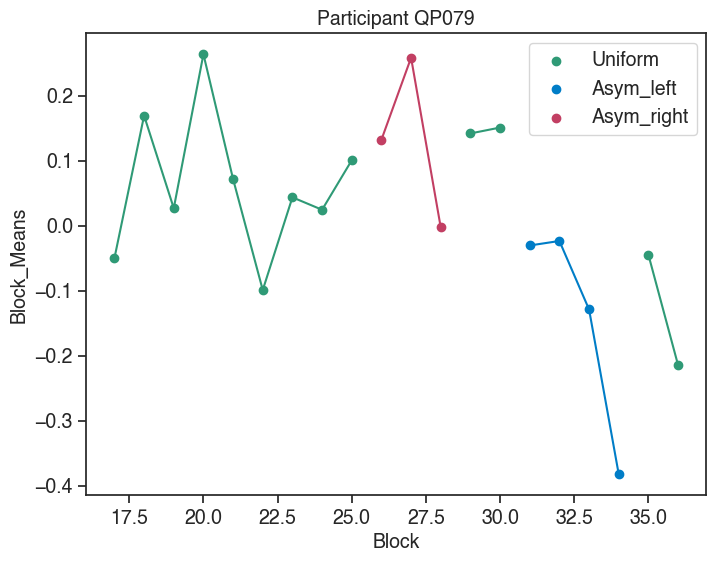

In [66]:
# Loop through each participant and create individual plots
for participant in p_ids:
    plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
    data_subset = psych_params_last_10_blocks[psych_params_last_10_blocks['Participant_ID'] == participant]
    
    for distribution, color in color_dict.items():
        distribution_data = data_subset[data_subset['Distribution'] == distribution]
        plt.scatter(distribution_data['Block'], distribution_data['Block_Means'], color=color, label=distribution)
        
        # Connect the dots with lines for consecutive blocks
        sorted_data = distribution_data.sort_values(by='Block')
        x = sorted_data['Block']
        y = sorted_data['Block_Means']
        for i in range(1, len(x)):
            if x.iloc[i] - x.iloc[i-1] == 1:
                plt.plot([x.iloc[i-1], x.iloc[i]], [y.iloc[i-1], y.iloc[i]], color=color)
    
    plt.xlabel('Block')
    plt.ylabel('Block_Means')
    plt.title(f'Participant {participant}')
    plt.legend()
    # plt.grid(True)
    plt.show()


In [41]:
data_df.columns

Index(['Participant_ID', 'Distribution', 'Trial', 'correct', 'Date',
       'stim_relative', 'stim_relative_binned', 'choice', 'No_response',
       'Response_Latency', 'stim_type', 'Choice_Rule_Diff', 'Anti_Bias',
       'Stim_Dur', 'Time', 'GoCueDur', 'ITI', 'ReponseWindow', 'Opto_ON',
       'Light_Freq', 'Perc_Opto_Trials', 'Opto_Onset', 'Opto_Offset', 'LED_ON',
       'block', 'dist_block', 'Cohort_ID'],
      dtype='object')

In [43]:
all_data_cont.columns

Index(['block', 'Trial_Number', 'Date', 'Animal_ID', 'Tone', 'FirstLick',
       'Correct', 'Rewside', 'TrialOutcome', 'AbortTrial', 'CorrectCount',
       'GoCueDur', 'ITI', 'ReponseWindow', 'Room_ID', 'Rig_ID',
       'Response_Latency', 'Distribution', 'Stim_Type', 'WN_Amp', 'Stim_Dur',
       'Anti_Bias', 'Stim_Relative', 'Speaker_Calib', 'Opto_ON', 'Light_Freq',
       'Perc_Opto_Trials', 'Opto_Onset', 'Opto_Offset', 'Time', 'LED_ON',
       'Dist_Exp_Rate', 'Incorrect', 'No_Response', 'Choice', 'Mask',
       'Stimulation_Type', 'Stimulation_Site', 'Unnamed: 0'],
      dtype='object')

In [ ]:
'Trial_Number', 'Date', 'Animal_ID',
'Correct', 'Rewside', 'TrialOutcome', 'Room_ID', 'Rig_ID',
'Response_Latency', 'Distribution', 'Stim_Type', 'WN_Amp', 'Stim_Dur',
'Anti_Bias', 'Stim_Relative', 'Speaker_Calib', 'Opto_ON', 'Light_Freq',
'Perc_Opto_Trials', 'Opto_Onset', 'Opto_Offset', 'Time', 'LED_ON',
'Dist_Exp_Rate', 'Incorrect', 'No_Response', 'Choice', 'Mask',
'Stimulation_Type', 'Stimulation_Site', 'Unnamed: 0'

In [48]:
data_df.stim_relative_binned[0]

0.375

In [49]:
data_df.stim_relative_binned

0         0.375
1         0.875
2        -0.875
3        -0.625
4         0.625
          ...  
529569    0.875
529570    0.375
529571   -0.625
529572    0.125
529573   -0.125
Name: stim_relative_binned, Length: 529574, dtype: category
Categories (8, float64): [-0.875 < -0.625 < -0.375 < -0.125 < 0.125 < 0.375 < 0.625 < 0.875]

## Conditional Psychometrics

In [ ]:
# apply the add_previous_trial_data to each group
data_df = data_df.groupby('Participant_ID', group_keys=False).apply(ut.add_previous_trial_data)

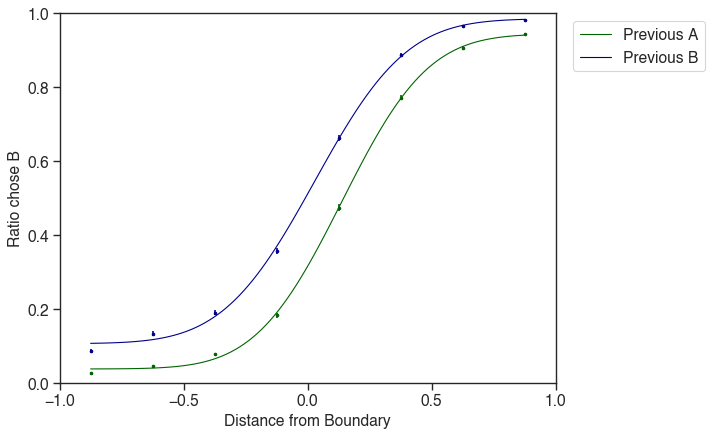

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

df_prev_A = data_df[data_df['choice_1'] == 0] 
df_prev_B = data_df[data_df['choice_1'] == 1]

ut.psycho_plot(df_prev_A, ut.psycho_fit(df_prev_A)[0], 
                label = 'Previous A', 
                color = 'darkgreen', 
                ax = ax)

ut.psycho_plot(df_prev_B, ut.psycho_fit(df_prev_B)[0], 
                label = 'Previous B', 
                color = 'darkblue', 
                ax = ax)            

# plt.title(animal_df.Participant_ID.unique()[0], fontsize=15)
plt.show()

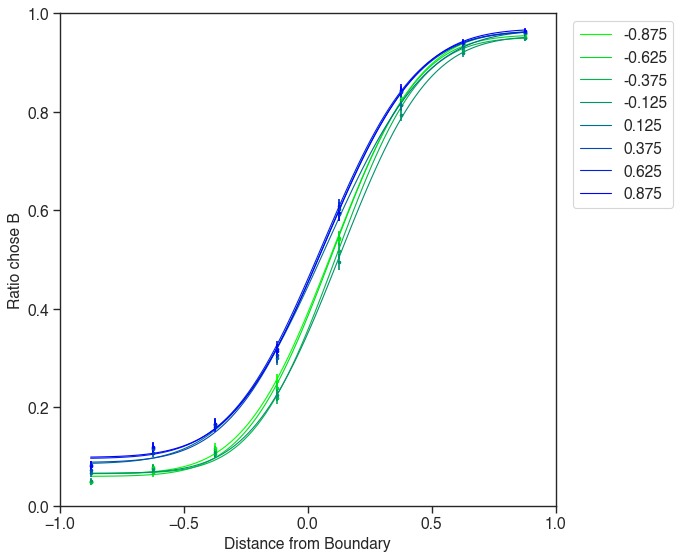

In [ ]:
# create a color map from dark green to dark blue
prev_stims = np.sort(data_df['stim_relative_1'].dropna().unique())

green_to_blue = mcolors.LinearSegmentedColormap.from_list('green_to_blue', ['#00FF00', '#0000FF'])
colors = [green_to_blue(i) for i in np.linspace(0, 1, len(prev_stims))]
fig, ax = plt.subplots(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

for i, stim_relative_1 in enumerate(prev_stims):
    stim_relative_1_df = data_df[data_df.stim_relative_1 == stim_relative_1]
    ut.psycho_plot(stim_relative_1_df, ut.psycho_fit(stim_relative_1_df)[0],
                   label = stim_relative_1, color = colors[i], ax = ax)


## Update Matrices

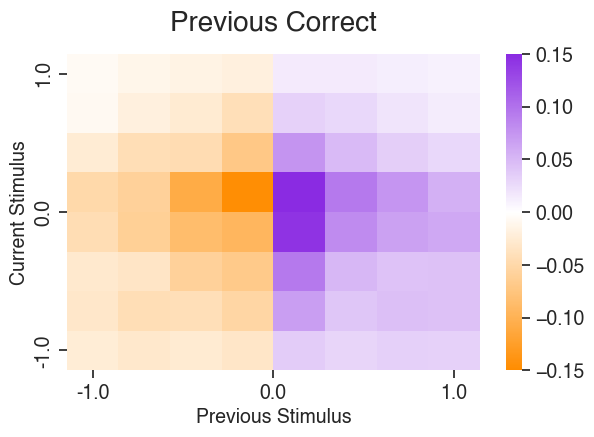

In [ ]:
# only get update matrix for certain animals
df = data_df[data_df.Participant_ID.isin(['QP033', 'QP034', 'QP050', 'QP051', 
                                          'QP062', 'QP063', 'QP070', 'QP071', 
                                        #   'QP079'
                                          ])]
ut.plot_update_matrix(ut.compute_update_matrix(df, prev_correct=True),
                                                   title = 'Previous Correct')

In [ ]:
# # plot update matrices for all distributions side by side
# for distribution in ['Uniform', 'Asym_left', 'Asym_right']:
#     dist_df = df[df['Distribution'] == distribution]
#     ut.plot_update_matrix(ut.compute_update_matrix(dist_df, prev_correct=True),
#                             title = distribution)

In [ ]:
# # plot update matrices for all distributions side by side
# for distribution in ['Uniform', 'Asym_left', 'Asym_right']:
#     dist_df = df[df['Distribution'] == distribution]
#     ut.plot_update_matrix(ut.compute_update_matrix(dist_df, prev_correct=False),
#                             title = distribution)

In [ ]:
# # flip the update matrix and calculate difference between rows 4-7 and 0-3
# distribution = 'Uniform'
# update_matrix = ut.compute_update_matrix(data_df[data_df['Distribution'] == distribution], prev_correct=True)
# diff = update_matrix[4:, :] - update_matrix[:4, :][::-1]
# cvals = [-1, 0, 1]
# colors = ['darkorange', 'white', 'blueviolet']
# norm2 = plt.Normalize(min(cvals), max(cvals))
# tuples = list(zip(map(norm2, cvals), colors))
# cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list('', tuples)

# g = sns.heatmap(diff, cmap=cmap2, vmin=-0.05, vmax=0.05)
# plt.title(distribution, size=20)
# plt.show()

In [ ]:
# # flip the update matrix and calculate difference between rows 4-7 and 0-3
# distribution = 'Asym_left'
# update_matrix = ut.compute_update_matrix(data_df[data_df['Distribution'] == distribution], prev_correct=True)
# diff = update_matrix[4:, :] - update_matrix[:4, :][::-1]
# cvals = [-1, 0, 1]
# colors = ['darkorange', 'white', 'blueviolet']
# norm2 = plt.Normalize(min(cvals), max(cvals))
# tuples = list(zip(map(norm2, cvals), colors))
# cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list('', tuples)

# g = sns.heatmap(diff, cmap=cmap2, vmin=-0.05, vmax=0.05)
# plt.title(distribution, size=20)
# plt.show()

In [ ]:
# # flip the update matrix and calculate difference between rows 4-7 and 0-3
# distribution = 'Asym_right'
# update_matrix = ut.compute_update_matrix(data_df[data_df['Distribution'] == distribution], prev_correct=True)
# diff = update_matrix[4:, :] - update_matrix[:4, :][::-1]
# cvals = [-1, 0, 1]
# colors = ['darkorange', 'white', 'blueviolet']
# norm2 = plt.Normalize(min(cvals), max(cvals))
# tuples = list(zip(map(norm2, cvals), colors))
# cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list('', tuples)

# g = sns.heatmap(diff, cmap=cmap2, vmin=-0.05, vmax=0.05)
# plt.title(distribution, size=20)
# plt.show()

## Choice Updating

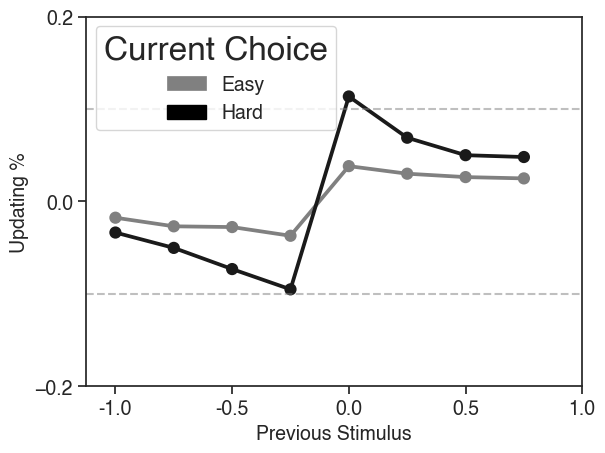

In [ ]:
ut.plot_choice_updating(ut.compute_update_matrix(df, prev_correct=True)) 

In [ ]:
# # plot choice updating for all distributions side by side
# # keep only df for stim_dut = 150ms
# df = df[df['Stim_Dur'] == 150]
# for distribution in ['Uniform', 'Asym_left', 'Asym_right']:
#     dist_df = df[df['Distribution'] == distribution]
#     ut.plot_choice_updating(ut.compute_update_matrix(dist_df, prev_correct=True),
#                             title = distribution)

In [ ]:
# # create an empty list to store dataframes
# dfs = []
# hard_row_indices = np.arange(2,6,1)

# with warnings.catch_warnings():
#     warnings.filterwarnings('ignore', r'All-NaN slice encountered')
    
# # loop through participant_id and block values to compute update_matrix and append to the list
#     for participant_id in data_df.Participant_ID.unique():
#         participant_df = data_df[data_df.Participant_ID == participant_id]
#         for block in participant_df.block.unique():
#             block_df = participant_df[participant_df.block == block]
#             block_update_matrix = ut.compute_update_matrix(block_df, prev_correct=True)
#             hard_rows = block_update_matrix[hard_row_indices, :]
#             hard_medians = np.nanmedian(hard_rows, axis=0)
#             hard_median_prev_A = np.nanmedian(hard_medians[:4])
#             hard_median_prev_B = np.nanmedian(hard_medians[4:])
#             grand_median = np.nanmedian(hard_medians)
#             df = pd.DataFrame({'Participant_ID': [participant_id], 'Block': [block], 
#                             'Update_Matrix': [block_update_matrix], 'Distribution': block_df.Distribution.unique(),
#                             'Hard_Median_Prev_A': [hard_median_prev_A], 'Hard_Median_Prev_B': [hard_median_prev_B],
#                             'Grand_Median': [grand_median]})
#             dfs.append(df)

# # concatenate the list of dataframes into a single dataframe
# df = pd.concat(dfs, ignore_index=True)

In [ ]:
# color_dict = {'Uniform': '#2F9A76', 'Asym_left': '#007dc7', 'Asym_right': '#c23f63'}

# # Create a plot for each participant
# for pid in df['Participant_ID'].unique():
#     # Filter the dataframe for each participant
#     df_participant = df[df['Participant_ID'] == pid]
    
#     # Create a plot for each distribution
#     for distribution, color in color_dict.items():
#         # Filter the dataframe for each distribution
#         df_distribution = df_participant[df_participant['Distribution'] == distribution]
        
#         # Iterate through the dataframe and plot line segments between adjacent points
#         for i in range(len(df_distribution) - 1):
#             current_block = df_distribution.iloc[i]['Block']
#             next_block = df_distribution.iloc[i + 1]['Block']
#             if next_block - current_block == 1:
#                 x_values = [current_block, next_block]
#                 y_values = [df_distribution.iloc[i]['Grand_Median'], df_distribution.iloc[i + 1]['Grand_Median']]
#                 plt.plot(x_values, y_values, color=color, label=distribution if i == 0 else "")
    
#     # Set the plot title and legend
#     plt.title(f'Participant {pid}')
#     plt.legend()
    
#     # Show the plot
#     plt.show()

## How does slope affect mean shift?

In [ ]:
# add sequence column that tracks the number of distribution switches

clean_psych_params_df = ut.add_dist_sequence_number(clean_psych_params_df)

/Users/quentin/Desktop/HeadFixedBehavior/Analysis/utils.py:1149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_psych_params_df.loc[:, 'Sequence'] = pd.Series(dtype='Int64')


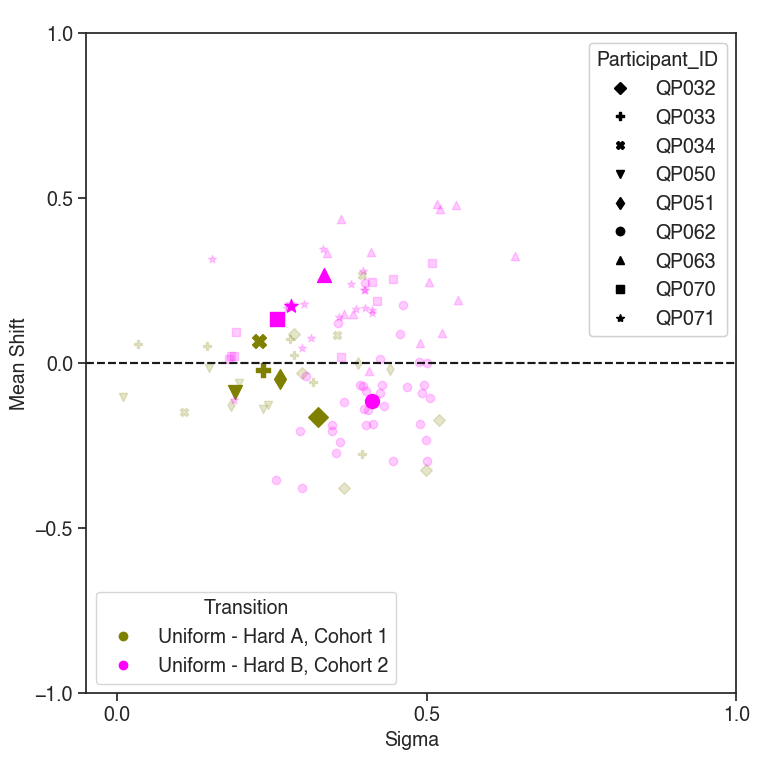

In [ ]:
cohort_dict_1 = {
  'df': clean_psych_params_df,
  'participants': ['QP032', 'QP033', 'QP034', 'QP050', 'QP051'],
  'markers': ['D', 'P', 'X', 'v', 'd'],
  'pre_dist': 'Uniform',
  'post_dist': 'Asym_right',
  'pre_sequence': 0,
  'post_sequence': 0,
  'color': 'olive',
  'ax': ax,
  'title': ' '
}

cohort_dict_2 = {
  'df': clean_psych_params_df,
  'participants': ['QP062', 'QP063', 'QP070', 'QP071'],
  'markers': ['o', '^', 's', '*'],
  'pre_dist': 'Uniform',
  'post_dist': 'Asym_left',
  'pre_sequence': 0,
  'post_sequence': 0,
  'color': 'magenta',
  'ax': ax,
  'title': ' '
}

legend = True
save_path = None
manual_legend = {'Uniform - Asym_right': 'Uniform - Hard A, Cohort 1', 'Uniform - Asym_left': 'Uniform - Hard B, Cohort 2'}

ut.plot_mean_shift_Vs_sigma_comp(cohort_dict_1, cohort_dict_2, 
                                 manual_legend=manual_legend)

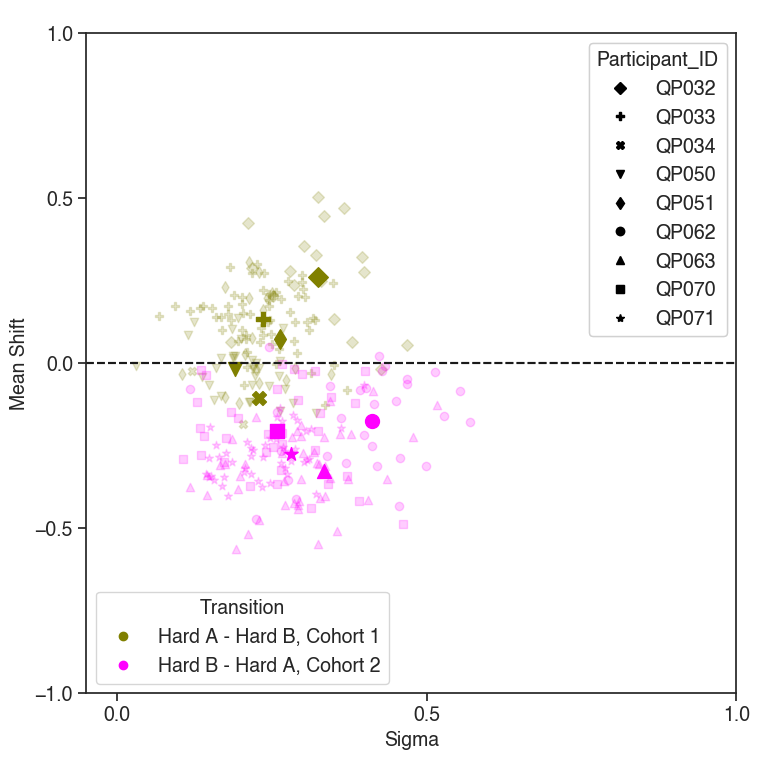

In [ ]:
cohort_dict_1 = {
  'df': clean_psych_params_df,
  'participants': ['QP032', 'QP033', 'QP034', 'QP050', 'QP051'],
  'markers': ['D', 'P', 'X', 'v', 'd'],
  'pre_dist': 'Asym_right',
  'post_dist': 'Asym_left',
  'pre_sequence': 0,
  'post_sequence': 0,
  'color': 'olive',
  'ax': ax,
  'title': ' '
}

cohort_dict_2 = {
  'df': clean_psych_params_df,
  'participants': ['QP062', 'QP063', 'QP070', 'QP071'],
  'markers': ['o', '^', 's', '*'],
  'pre_dist': 'Asym_left',
  'post_dist': 'Asym_right',
  'pre_sequence': 0,
  'post_sequence': 0,
  'color': 'magenta',
  'ax': ax,
  'title': ' '
}

legend = True
save_path = None
manual_legend = {'Asym_right - Asym_left': 'Hard A - Hard B, Cohort 1', 'Asym_left - Asym_right': 'Hard B - Hard A, Cohort 2'}

ut.plot_mean_shift_Vs_sigma_comp(cohort_dict_1, cohort_dict_2, 
                                 manual_legend=manual_legend)

## Stattic GLM

In [ ]:
# I have an exepriment in which a mouse learns how to categorize sounds (lower than boundary Vs higher than boundary)
# I am interested in manipulation the sensory statistics of the sounds to see 2 things: 1) how does the mouse adapt to the new statistics (if it can)
# 2) what exactly is the mouse learning? Is it learning the statistics of the sounds or is it learning the boundary between the sounds?
# Design an experiment to distinguish between these two possibilities

# Cross Validation - error bars & multinomial distribution

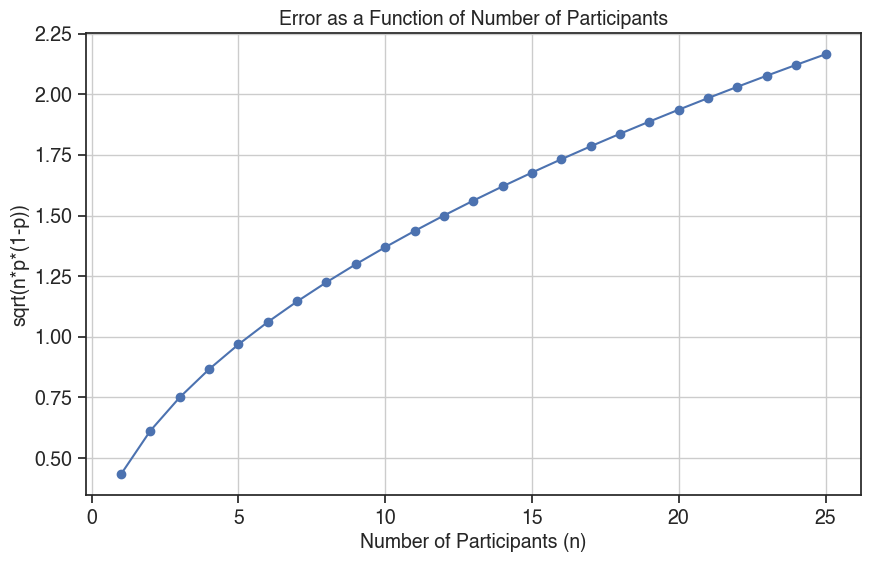

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set the probability
p = 0.25

# Generate a range of n values
n_values = np.arange(1, 26, 1)

# Calculate sqrt(np(1-p)) for each n
error_values = np.sqrt(n_values * p * (1 - p))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(n_values, error_values, marker='o')
 
# Label the plot
plt.xlabel('Number of Participants (n)')
plt.ylabel('sqrt(n*p*(1-p))')
plt.title('Error as a Function of Number of Participants')
plt.grid(True)
plt.show()


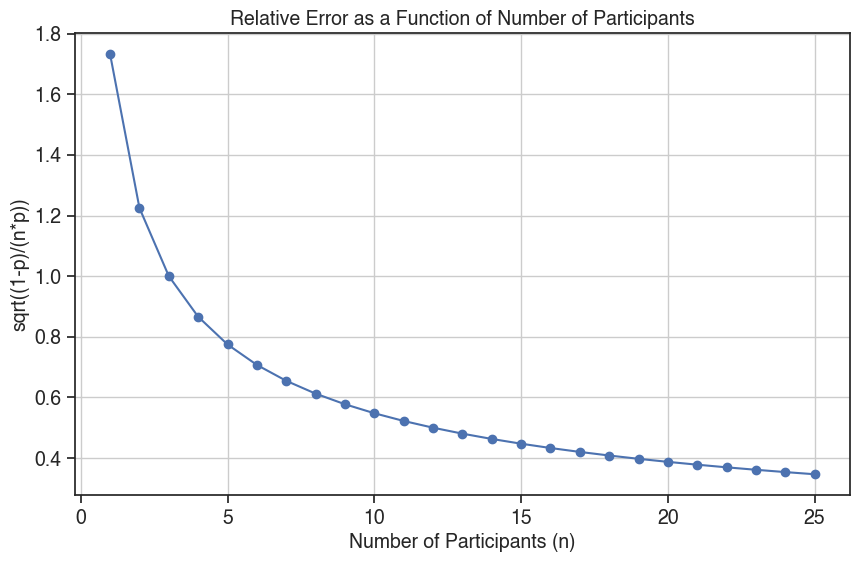

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set the probability
p = 0.25

# Generate a range of n values
n_values = np.arange(1, 26, 1)

# Calculate sqrt((1-p)/(n*p)) for each n
relative_error_values = np.sqrt((1 - p) / (n_values * p))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(n_values, relative_error_values, marker='o')

# Label the plot
plt.xlabel('Number of Participants (n)')
plt.ylabel('sqrt((1-p)/(n*p))')
plt.title('Relative Error as a Function of Number of Participants')
plt.grid(True)
plt.show()


## Recover stimulus durations

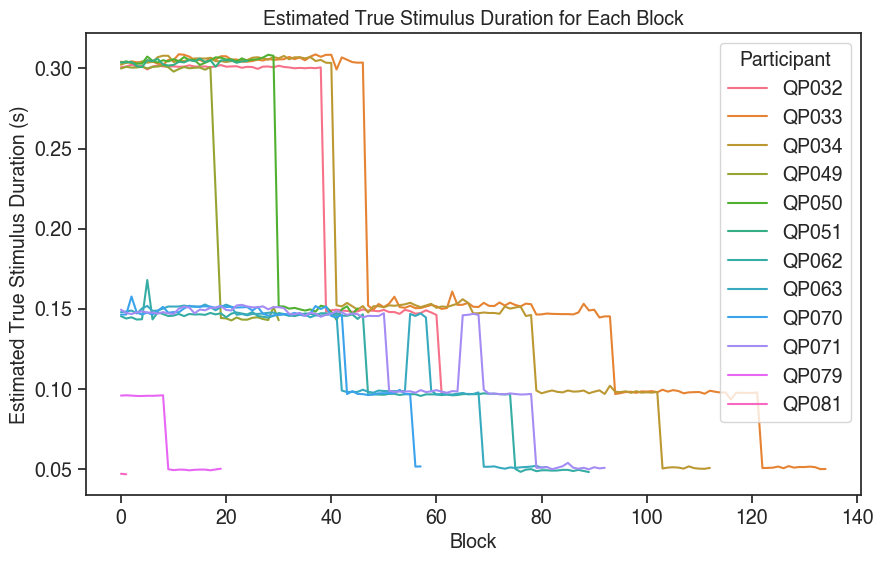

In [ ]:
# plot the mean stimulus duration for each block for each participant
plt.figure(figsize=(10, 6))
sns.lineplot(x='Block', y='Estimated_True_Stim_Dur', hue='Participant', data=ut.calculate_stim_dur(data_df))
plt.xlabel('Block')
plt.ylabel('Estimated True Stimulus Duration (s)')
plt.title('Estimated True Stimulus Duration for Each Block')
plt.show()